# ALS applications

## Implement ALS, IALS (20 points each)

In [2]:
import numpy as np

In [3]:
import numpy as np

def als(ratings: np.ndarray, k: int, iterations=10, alpha=0.01, lambda_reg=0.1):
    num_users, num_items = ratings.shape
    user_embeddings = np.random.rand(num_users, k)
    item_embeddings = np.random.rand(num_items, k)

    # print("user_embeddings shape:", user_embeddings.shape)
    # print("item_embeddings shape:", item_embeddings.shape)
    for _ in range(iterations):
        for u in range(num_users):
            item_indices = ratings[u, :].nonzero()[0]  # Items rated by user u
            if len (item_indices) == 0:
                continue
            M = item_embeddings[item_indices, :]
            r = ratings[u, item_indices]        
            r = r.reshape(-1, 1)
            user_embeddings[u, :] = (M.T @ r).flatten()
        for i in range(num_items):
            user_indices = ratings[:, i].nonzero()[0]  
            if len(user_indices) == 0:
                continue
            M = user_embeddings[user_indices, :]
            r = ratings[user_indices, i]
            r = r.reshape(-1, 1)
            item_embeddings[i, :] = (M.T @ r).flatten()
    return user_embeddings, item_embeddings


In [4]:
num_users = 5
num_items = 4
k = 2
ratings = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4]
])
user_embeddings, item_embeddings = als(ratings, k)
assert user_embeddings.shape == (num_users, k)
assert item_embeddings.shape == (num_items, k)
print(user_embeddings)
print(item_embeddings)

[[5.44219299e+17 3.96500568e+17]
 [3.70177806e+17 2.69701444e+17]
 [6.42770504e+17 4.68445307e+17]
 [4.98367154e+17 3.63206243e+17]
 [6.76389854e+17 4.93012889e+17]]
[[5.34294538e+18 3.89296016e+18]
 [2.95181826e+18 2.15095990e+18]
 [3.38194927e+18 2.46506444e+18]
 [8.82727766e+18 6.43330507e+18]]


In [5]:
import numpy as np
from scipy.sparse import csr_matrix

def ials(ratings: csr_matrix, k: int, iterations=10, alpha=40, lambda_reg=0.1):
    num_users, num_items = ratings.shape
    user_embeddings = np.random.rand(num_users, k)
    item_embeddings = np.random.rand(num_items, k)
    # print("user_embeddings shape:", user_embeddings.shape)
    # print("item_embeddings shape:", item_embeddings.shape)
    C = alpha * ratings.copy()
    for _ in range(iterations):
        for u in range(num_users):
            confidence = C[u, :].toarray().flatten()
            item_indices = confidence.nonzero()[0]

            if len(item_indices) == 0:
                continue
            M = item_embeddings[item_indices, :]
            C_u = np.diag(confidence[item_indices])
            user_embeddings[u, :] = np.linalg.solve(M.T @ C_u @ M + lambda_reg * np.eye(k), M.T @ C_u @ confidence[item_indices])
        for i in range(num_items):
            confidence = C[:, i].toarray().flatten()
            user_indices = confidence.nonzero()[0]
            if len(user_indices) == 0:
                continue
            M = user_embeddings[user_indices, :]
            C_i = np.diag(confidence[user_indices])
            item_embeddings[i, :] = np.linalg.solve(M.T @ C_i @ M + lambda_reg * np.eye(k), M.T @ C_i @ confidence[user_indices])

    return user_embeddings, item_embeddings


## Read Dzen dataset (no points, already imlemented)

Data comes from [dzen.ru](http://dzen.ru/) site and consists of likes which users put to text articles

### Columns
1. item_id - unique id of an item (article)
2. user_id - unique id of a user
3. source_id - unique id of an author. If two items have same source_id, then they come from one author
4. Name of item is name of the article
5. Raw dataset represents user_id and list of item_ids which user liked

### Data files

You need to download it to current directory

1. Dataset: https://disk.yandex.ru/d/uUx1MMsZUR87Sw
2. Item names: https://disk.yandex.ru/d/_ZMXsmki-OtLJA
3. item_id and source_id links: https://disk.yandex.ru/d/GCryohhLbYPFoA

In [6]:
import pandas as pd
import scipy.sparse as sp
from tqdm.notebook import tqdm

In [7]:
all_names = pd.read_json("item_id_to_name.json", lines=False)
item_links = pd.read_json("item_id_to_source_id.json", lines=False)
dataset = pd.read_json("dataset_zen.json", lines=False)

In [8]:
all_names

,id,name
0,94962,Что обычно ожидало русских казачек в руках у к...
1,3972,Почему Россия решила строить новую скоростную ...
2,94644,"5 неприличных фактов об Андрее Макаревиче, кот..."
3,82518,"Что стало с красавицей Хмельницкой, которую му..."
4,53264,"Понять и Простить: Почему угонщики, бежавшие и..."
...,...,...
104498,36769,"Плюс один источник мифа о рыцарях, неспособных..."
104499,9190,Мой сад - малоуходный
104500,52731,Купил первую в жизни циркулярную пилу. Честный...
104501,72660,Решили предложить Марине помощь в лечении ч.10


In [9]:
item_links

,id,source
0,94962,2919814402697966089
1,3972,3263022753228392991
2,94644,-3857390427602554682
3,82518,-9036908390349249792
4,53264,3353856219169766284
...,...,...
104498,36769,3818746211375738614
104499,9190,4975535765688979937
104500,52731,3720366796439288909
104501,72660,-7860042973720636310


In [10]:
dataset

,user_id,item_ids
0,993675863667353526,"[15267, 61075, 81203, 17066, 25471, 88427, 638..."
1,4250619547882954185,"[4555, 94644, 84972, 17774, 94962, 78217, 2485..."
2,3847785305345691076,"[1898, 26703, 16525, 86939, 55017, 31069, 4035..."
3,1785181112918558233,"[75601, 102458, 28716, 100694, 5757, 47104, 60..."
4,5078748097863903181,"[72260, 40825, 2615, 42549, 379, 100818, 56827..."
...,...,...
75905,4954138831959898373,"[11881, 55520, 63054, 48015, 66952, 103830, 21..."
75906,4967793435819938014,"[74697, 11830, 63858, 87245, 41956, 62089, 686..."
75907,7137764184903122777,"[10353, 1775, 103680, 29704, 9782, 13295, 9975..."
75908,2624987805086334956,"[24324, 18854, 73319, 66641, 64078, 97387, 426..."


In [11]:
total_interactions_count = dataset.item_ids.map(len).sum()
user_coo = np.zeros(total_interactions_count, dtype=np.int64)
item_coo = np.zeros(total_interactions_count, dtype=np.int64)
pos = 0

for user_id, item_ids in enumerate(tqdm(dataset.item_ids)):
    user_coo[pos : pos + len(item_ids)] = user_id
    item_coo[pos : pos + len(item_ids)] = item_ids
    pos += len(item_ids)
shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
user_item_matrix = user_item_matrix.tocsr()
sp.save_npz("data_train.npz", user_item_matrix)
# Cleanup memory. Later you need just data_train.npz
del user_coo
del item_coo
del dataset

  0%|          | 0/75910 [00:00<?, ?it/s]

In [12]:
# you could start here if you already done precomputing
user_item_matrix = sp.load_npz("data_train.npz")

In [13]:
user_item_matrix

<75910x104503 sparse matrix of type '<class 'numpy.float64'>'
	with 5792423 stored elements in Compressed Sparse Row format>

In [14]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]


def build_dataset(user_item_matrix, item_pct, user_pct):
    user_count, item_count = int(total_user_count * user_pct), int(
        total_item_count * item_pct
    )
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(
        np.arange(user_item_matrix.shape[0]), size=user_count, replace=False
    )
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

In [15]:
small_dataset = build_dataset(user_item_matrix, 0.01, 0.01)

In [16]:
main_dataset = build_dataset(user_item_matrix, 0.1, 0.1)

## Split dataset matrix (10 points)

in the following way: for 20% of users (random) remove one like - this will be test data. The rest is train data. (10 points)

In [17]:
import scipy.sparse as sp
def split_data(user_item_matrix, test_user_pct=0.2):
    train_matrix = user_item_matrix.copy()
    test_matrix = user_item_matrix.copy()

    total_users = user_item_matrix.shape[0]

    for user_id in range(total_users):
        if np.random.rand() < test_user_pct:
            liked_indices = train_matrix[user_id].nonzero()[1]
            if liked_indices.size > 0:
                item_to_remove = np.random.choice(liked_indices)
                test_matrix[user_id, item_to_remove] = 0  # Remove the like from the test set
                train_matrix[user_id, item_to_remove] = 0  # Remove the like from the train set
    train_matrix = train_matrix.tocsr()
    test_matrix = test_matrix.tocsr()
    return train_matrix, test_matrix
train_matrix, test_matrix = split_data(main_dataset, test_user_pct=0.2)


In [18]:
train_matrix.shape

(7591, 10038)

In [19]:
test_matrix.shape

(7591, 10038)

In [20]:
user_item_matrix.shape

(75910, 104503)

## Compute MRR@100 metric for test users (10 points)

For ALS and IALS algorithms

In [21]:
user_embeddings, item_embeddings = als(train_matrix, k=5, iterations=1, alpha=0.01, lambda_reg=0.1)


In [22]:
def mrr(predictions, test_ratings):
    mrr_sum = 0.0
    num_users = test_ratings.shape[0]

    for user_id in range(num_users):
        predicted_scores = predictions[user_id]
        test_items = test_ratings[user_id].nonzero()[1]
        sorted_items = [item for item, score in sorted(enumerate(predicted_scores), key=lambda x: x[1], reverse=True)]
        for rank, item in enumerate(sorted_items[:min(100, len(sorted_items))], 1):
            if test_items.size > 0 and item in test_items:
                mrr_sum += 1.0 / rank
                break  
    mrr_value = mrr_sum / num_users
    return mrr_value

In [23]:
als_predictions = np.dot(user_embeddings, item_embeddings.T)
mrr_als = mrr(als_predictions, test_matrix)
print("MRR ALS @100:", mrr_als)

MRR ALS @100: 0.17472572748568868


In [24]:
user_embeddings_ails, item_embeddings_ails = ials(train_matrix, k=5, iterations=1, lambda_reg=0.1)
ials_predictions = np.dot(user_embeddings_ails, item_embeddings_ails.T)


In [25]:
mrr_ials = mrr(ials_predictions, test_matrix)
print(mrr_ials)

0.0014561193986376644


## Adjust hyperparameters of ALS and IALS to maximize MRR (30 points)

Main hyperparameters are regularization and weights for implicit case.

### I used Grid search for ALS and random search for iALS 

In [27]:
best_mrr_als = -1
best_hyperparams_als = {}

k_values = [10, 20, 50]
alpha_values = [0.01, 0.1, 0.5]
lambda_values = [0.01, 0.1, 1.0]

for k in tqdm(k_values, desc='Grid Search ALS'):
    for alpha in alpha_values:
        for lambda_reg in lambda_values:
            user_embeddings, item_embeddings = als(train_matrix, k=k, iterations=1, alpha=alpha, lambda_reg=lambda_reg)
            als_predictions = np.dot(user_embeddings, item_embeddings.T)
            mrr_als = mrr(als_predictions, test_matrix)

            if mrr_als > best_mrr_als:
                best_mrr_als = mrr_als
                best_hyperparams_als = {'k': k, 'alpha': alpha, 'lambda_reg': lambda_reg}

print("Best hyperparameters for ALS:", best_hyperparams_als)
print("Best MRR ALS @100:", best_mrr_als)


Grid Search ALS:   0%|          | 0/3 [00:00<?, ?it/s]

Best hyperparameters for ALS: {'k': 10, 'alpha': 0.01, 'lambda_reg': 0.01}
Best MRR ALS @100: 0.17472572748568868


In [28]:
best_mrr_ials = -1
best_hyperparams_ials = {}

random_search_iterations = 3

for _ in tqdm(range(random_search_iterations), desc='Random Search IALS'):
    k = np.random.choice(k_values)
    alpha = np.random.choice(alpha_values)
    lambda_reg = np.random.choice(lambda_values)

    user_embeddings_ials, item_embeddings_ials = ials(train_matrix, k=k, iterations=1, lambda_reg=lambda_reg)
    ials_predictions = np.dot(user_embeddings_ials, item_embeddings_ials.T)
    mrr_ials = mrr(ials_predictions, test_matrix)

    if mrr_ials > best_mrr_ials:
        best_mrr_ials = mrr_ials
        best_hyperparams_ials = {'k': k, 'alpha': alpha, 'lambda_reg': lambda_reg}

print("Best hyperparameters for IALS:", best_hyperparams_ials)
print("Best MRR IALS @100:", best_mrr_ials)

Random Search IALS:   0%|          | 0/3 [00:00<?, ?it/s]

Best hyperparameters for IALS: {'k': 50, 'alpha': 0.1, 'lambda_reg': 0.1}
Best MRR IALS @100: 0.0027871976174532356


## Get similarities from item2item CF and SLIM (10 points each)

Item2item can be taken from the first homework, SLIM was implemented in the class.

You need to compute only item similarities, not predictions for users.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def item_item_cf_similarity(ratings: np.ndarray):
    item_similarity = cosine_similarity(ratings.T, dense_output=False)
    return item_similarity

In [30]:
i2i_similarities = item_item_cf_similarity(train_matrix)

In [31]:
i2i_similarities.shape

(10038, 10038)

## Slim took sooo long and i had to finish it before the deadline so in the next function i took a subsample.

In [32]:
from sklearn.linear_model import ElasticNet

def slim_similarity(ratings, alpha=0.01, l1_ratio=0.1):
    num_items = ratings.shape[1]
    item_similarity = np.zeros((num_items, num_items))

    for i in tqdm(range(num_items), desc='Calculating SLIM Similarity'):
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
        target_ratings = ratings[:, i].copy()
        
        target_ratings[target_ratings > 0] = 1
        target_ratings = target_ratings.toarray().ravel()
        target_ratings = target_ratings.astype(float)
        model.fit(ratings, target_ratings)
        item_similarity[i, :] = model.coef_
    
    item_similarity = item_similarity / np.sum(np.abs(item_similarity), axis=1)

    return item_similarity


In [33]:
item_similarity_slim = slim_similarity(train_matrix)

Calculating SLIM Similarity:   0%|          | 0/10038 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
def slim_similarity_subsampled_items(ratings, alpha=0.01, l1_ratio=0.1, subsample_fraction=0.1):
    num_items = ratings.shape[1]
    num_items_to_sample = int(subsample_fraction * num_items)
    sampled_item_indices = np.random.choice(num_items, num_items_to_sample, replace=False)
    item_similarity = np.zeros((num_items, num_items))
    for i in tqdm(sampled_item_indices, desc='Calculating SLIM Similarity'):
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
        target_ratings = ratings[:, i].copy()
        target_ratings[target_ratings > 0] = 1
        target_ratings = target_ratings.toarray().ravel()
        target_ratings = target_ratings.astype(float)
        model.fit(ratings[:, sampled_item_indices], target_ratings)
        item_similarity[i, sampled_item_indices] = model.coef_
    item_similarity = item_similarity / np.sum(np.abs(item_similarity), axis=1)
    return item_similarity
item_similarity_slim_subsampled = slim_similarity_subsampled_items(train_matrix)


Calculating SLIM Similarity:   0%|          | 0/1003 [00:00<?, ?it/s]

/var/folders/ym/28xx549x3z9g7t4t99hld8gh0000gn/T/ipykernel_6170/1302410049.py:14: RuntimeWarning: invalid value encountered in divide
  item_similarity = item_similarity / np.sum(np.abs(item_similarity), axis=1)


## Compare similarities from four algorithms (20 points)

* plot distributions
* compute metrics (which you think are relevant)
* look at several top similar lists

Make conclusion how these methods differ in computing similarities

In [35]:
item_similarity_ials = cosine_similarity(item_embeddings_ails)


In [36]:
item_similarity_als = cosine_similarity(item_embeddings)

Text(0.5, 1.0, 'iALS Similarity Distribution')

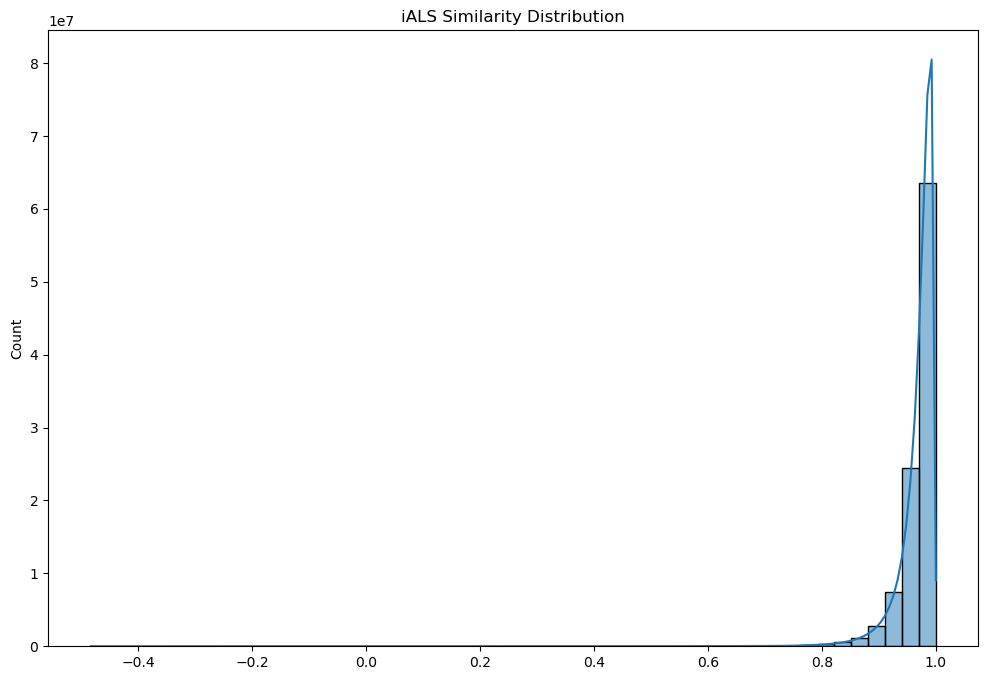

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
sns.histplot(item_similarity_ials.flatten(), bins=50, kde=True)
plt.title('iALS Similarity Distribution')





Text(0.5, 1.0, 'ALS Similarity Distribution')

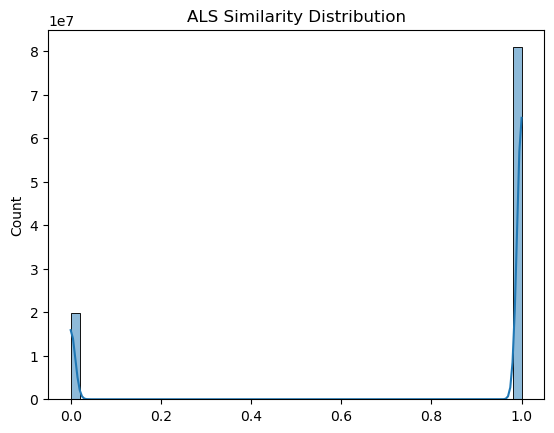

In [39]:
sns.histplot(item_similarity_als.flatten(), bins=50, kde=True)
plt.title('ALS Similarity Distribution')

Text(0.5, 1.0, 'SLIM Similarity Distribution')

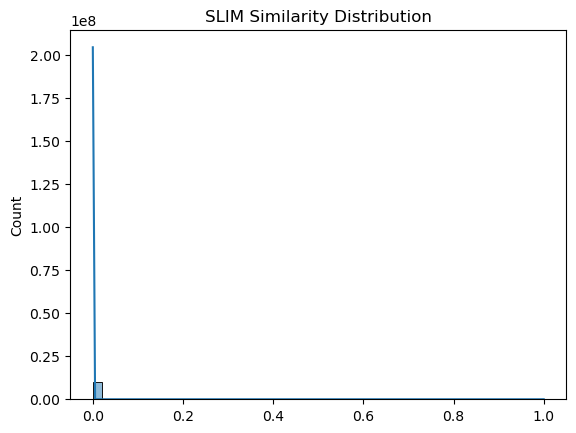

In [41]:
sns.histplot(item_similarity_slim_subsampled.flatten(), bins=50, kde=True)
plt.title('SLIM Similarity Distribution')


Text(0.5, 1.0, 'I2I Similarity Distribution')

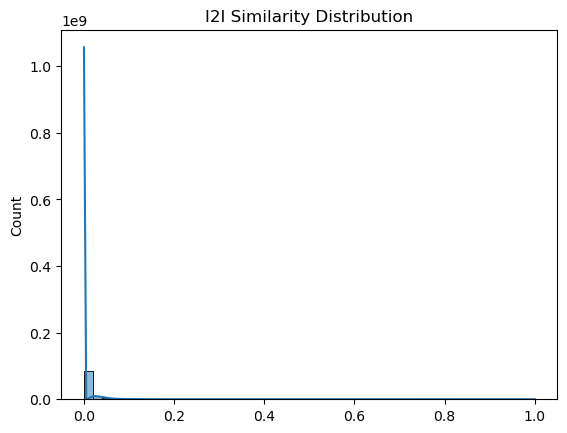

In [42]:
sns.histplot(i2i_similarities.toarray().flatten(), bins=50, kde=True)
plt.title('I2I Similarity Distribution')

In [43]:
metrics = {
    'iALS': {
        'mean': item_similarity_ials.mean(),
        'median': np.median(item_similarity_ials),
        'std': item_similarity_ials.std(),
        'min': item_similarity_ials.min(),
        'max': item_similarity_ials.max()
    },
    'ALS': {
        'mean': item_similarity_als.mean(),
        'median': np.median(item_similarity_als),
        'std': item_similarity_als.std(),
        'min': item_similarity_als.min(),
        'max': item_similarity_als.max()
    },
    'SLIM': {
        'mean': item_similarity_slim_subsampled.mean(),
        'median': np.median(item_similarity_slim_subsampled),
        'std': item_similarity_slim_subsampled.std(),
        'min': item_similarity_slim_subsampled.min(),
        'max': item_similarity_slim_subsampled.max()
    },
    'I2I': {
        'mean': i2i_similarities.mean(),
        'median': np.median(i2i_similarities.toarray()),
        'std': i2i_similarities.data.std(),

        'min': i2i_similarities.min(),
        'max': i2i_similarities.max()
    }
}

print("Metrics:")
print(metrics)
top_n = 5
example_item_indices = [0, 1, 2] 

for algorithm, similarity_matrix in zip(['iALS', 'ALS', 'SLIM', 'I2I'],
                                        [item_similarity_ials, item_similarity_als, item_similarity_slim_subsampled, i2i_similarities]):
    print(f"\nTop {top_n} similar items using {algorithm}:\n")
    for item_index in example_item_indices:
        # Find top N similar items for each example
        top_similar_indices = np.argsort(similarity_matrix[item_index, :])[::-1][:top_n]
        print(f"Item {item_index}: {top_similar_indices}")


Metrics:
{'iALS': {'mean': 0.9678734187891216, 'median': 0.9780042551889133, 'std': 0.03824300352559569, 'min': -0.48351584858823543, 'max': 1.0000000000000004}, 'ALS': {'mean': 0.802807430985209, 'median': 1.0, 'std': 0.39787895111470684, 'min': 0.0, 'max': 1.0000000000000009}, 'SLIM': {'mean': nan, 'median': nan, 'std': nan, 'min': nan, 'max': nan}, 'I2I': {'mean': 0.008505860358965424, 'median': 0.0, 'std': 0.0389378764711437, 'min': 0.0, 'max': 1.0000000000000109}}

Top 5 similar items using iALS:

Item 0: [   0 8695 8240 4686  799]
Item 1: [   1 5256 9989 9083 7795]
Item 2: [   2 1202 7515 1067 6368]

Top 5 similar items using ALS:

Item 0: [8055 9838 3520 3521 5238]
Item 1: [7146 1309 4987 8329 6303]
Item 2: [3336 7588 3447 8704 6868]

Top 5 similar items using SLIM:

Item 0: [10037  3523  3521  3519  3518]
Item 1: [10037  3523  3521  3519  3518]
Item 2: [10037  3523  3521  3519  3518]

Top 5 similar items using I2I:

Item 0: [0]
Item 1: [0]
Item 2: [0]


## Conclusion:

....

Unfortunately the SLIM algorithm's similarity metrics resulted in NaN values, which might be due to some numerical instability or an issue with the implementation!!

**For the other algorithms:**

iALS: The mean and median values are relatively high, showing a strong positive similarity. The standard deviation is relatively low, suggesting that the values are clustered around the mean. The minimum and maximum values indicate a range from negative to positive similarities.

ALS: Similar to iALS, ALS shows high mean and median values, with a wider standard deviation. The minimum is 0, and the maximum is 1, suggesting a binary nature of the similarities.

I2I: The mean and median are low, indicating weaker overall similarities. The standard deviation is relatively high, suggesting a wider spread of values. The minimum is 0, and the maximum is 1, indicating binary similarities.

